<h2 style="text-align: center;"><strong>Projet Multidisciplinaire : Analyse des sentiments</strong></h2>
<h3 style="text-align: left;">Réalisé par  :</h3>
<ul>
<li>ARI Chaymaa</li>
<li>ASSAG Khadija</li>
<li>LEBNAITI Rajaa </li>
<li>LAFHAL Nessrine</li>
</ul>

### <b>Les bibliothèques :</b>

In [5]:
## Creating the spark session
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.sql.functions import udf
import re
from string import punctuation
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace, lower, col, concat_ws, split, array_except , lit ,collect_list
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
import numpy as np

### <b>Création d'une session Spark nommée "NB"</b>

In [6]:

spark =SparkSession.builder.appName("NB").getOrCreate()

In [7]:
# Accéder à l'objet SparkContext via la session
sc = spark.sparkContext

# Obtenir la configuration Spark
spark_conf = sc.getConf()

# Afficher la configuration Spark
for conf in spark_conf.getAll():
    print(conf)

('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.app.submitTime', '1731777995155')
('spark.executor.id', 'driver')
('spark.driver.host', '192.168.1.

### <b>Chargement des données depuis des fichiers CSV dans Spark</b>

In [8]:
##  DATA LOADING
df_train = spark.read.csv('./Dataset/train.csv', inferSchema=True, header=True ,encoding="ISO-8859-1")
df_test = spark.read.csv('./Dataset/test.csv', inferSchema=True, header=True ,encoding="ISO-8859-1")

In [9]:
print("train dataset")
df_train.show()

train dataset
+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|    textID|                text|       selected_text|sentiment|Time of Tweet|Age of User|            Country|Population -2020|Land Area (Km²)|Density (P/Km²)|
+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|cb774db0d1| I`d have respond...|I`d have responde...|  neutral|      morning|       0-20|        Afghanistan|        38928346|       652860.0|             60|
|549e992a42| Sooo SAD I will ...|            Sooo SAD| negative|         noon|      21-30|            Albania|         2877797|        27400.0|            105|
|088c60f138|my boss is bullyi...|         bullying me| negative|        night|      31-45|            Algeria|        43851044|      2381740.0|             18|
|9642c003ef| what intervie

In [10]:
print("test dataset")
df_test.show()

test dataset


+----------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|    textID|                text|sentiment|Time of Tweet|Age of User|            Country|Population -2020|Land Area (Km²)|Density (P/Km²)|
+----------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|f87dea47db|Last session of t...|  neutral|      morning|       0-20|        Afghanistan|        38928346|       652860.0|             60|
|96d74cb729| Shanghai is also...| positive|         noon|      21-30|            Albania|         2877797|        27400.0|            105|
|eee518ae67|Recession hit Ver...| negative|        night|      31-45|            Algeria|        43851044|      2381740.0|             18|
|01082688c6|         happy bday!| positive|      morning|      46-60|            Andorra|           77265|          470.0|            164|
|33987a8ee5| http://twitpic

# <b> Partie 1:Prétraitement </b>

### <b>Suppression des valeurs nulles et comptage des lignes</b>

In [11]:
## Supprimer les nulls
# Afficher le nombre de lignes dans l'ensemble d'entraînement
# Supprimer les nulls
df_train= df_train.dropna()
df_train_count = df_train.count()
print("Nombre de lignes dans l'ensemble d'entraînement:", df_train_count)

# Afficher le nombre de lignes dans l'ensemble test
# Supprimer les nulls
df_test = df_test.dropna()
df_test_count = df_test.count()
print("Nombre de lignes dans l'ensemble d'entraînement:", df_test_count)

Nombre de lignes dans l'ensemble d'entraînement: 27478
Nombre de lignes dans l'ensemble d'entraînement: 3534


### <b>Sélectionner uniquement les colonnes 'text' et 'sentiment' dans les ensembles d'entraînement et de test, puis les fusionner et afficher le DataFrame</b>

In [12]:
df_train=df_train['text', 'sentiment']
df_test=df_test['text', 'sentiment']
df = df_train.union(df_test)
df.show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
| I`d have respond...|  neutral|
| Sooo SAD I will ...| negative|
|my boss is bullyi...| negative|
| what interview! ...| negative|
| Sons of ****, wh...| negative|
|http://www.dotheb...|  neutral|
|2am feedings for ...| positive|
|          Soooo high|  neutral|
|         Both of you|  neutral|
| Journey!? Wow......| positive|
| as much as i lov...|  neutral|
|I really really l...| positive|
|My Sharpie is run...| negative|
|i want to go to m...| negative|
|test test from th...|  neutral|
|Uh oh, I am sunbu...| negative|
| S`ok, trying to ...| negative|
|i`ve been sick fo...| negative|
|is back home now ...| negative|
|Hes just not that...|  neutral|
+--------------------+---------+
only showing top 20 rows



### <b>supprimer les duplications dans le DataFrame et afficher les statistiques descriptives avant et après la suppression</b>

In [13]:
##Affichage des statistiques descriptive avant suppression
print("Avant supression :")
df.describe().show()
## Supprimer les duplications
df = df.dropDuplicates()
##Affichage des statistiques descriptive apres suppression
print("Après supression :")
df.describe().show()

Avant supression :
+-------+--------------------+---------+
|summary|                text|sentiment|
+-------+--------------------+---------+
|  count|               31012|    31012|
|   mean|                NULL|     NULL|
| stddev|                NULL|     NULL|
|    min|\tREALLY?? oh.. s...| negative|
|    max|Ã¯Â¿Â½Ã¯Â¿Â½h. iÃ...| positive|
+-------+--------------------+---------+

Après supression :
+-------+--------------------+---------+
|summary|                text|sentiment|
+-------+--------------------+---------+
|  count|               31012|    31012|
|   mean|                NULL|     NULL|
| stddev|                NULL|     NULL|
|    min|\tREALLY?? oh.. s...| negative|
|    max|Ã¯Â¿Â½Ã¯Â¿Â½h. iÃ...| positive|
+-------+--------------------+---------+



### <b>Visualiser le nombre de sentiments différents</b>

In [14]:
#visualiser les sentiment
df.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive| 9685|
|  neutral|12547|
| negative| 8780|
+---------+-----+



### <b>Encodage des sentiments et visualisation</b>

In [15]:
## Encoder les sentiments
# Définir le dictionnaire de remplacement
replacement_dict = {"positive": 1, "neutral": 0, "negative": 2}

# Remplacer les valeurs dans la colonne "sentiment" en fonction du dictionnaire de remplacement
df = df.withColumn("sentiment",
                   when(df["sentiment"] == "positive", replacement_dict["positive"])
                   .when(df["sentiment"] == "neutral", replacement_dict["neutral"])
                   .when(df["sentiment"] == "negative", replacement_dict["negative"])
                   .otherwise(df["sentiment"]))
#visualiser les sentiment
# Convertir la colonne "sentiment" en type entier
df = df.withColumn("sentiment", col("sentiment").cast("int"))

df.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|        1| 9685|
|        2| 8780|
|        0|12547|
+---------+-----+



### <b>Visualisation du décompte des sentiments</b>

<Axes: xlabel='sentiment', ylabel='count'>

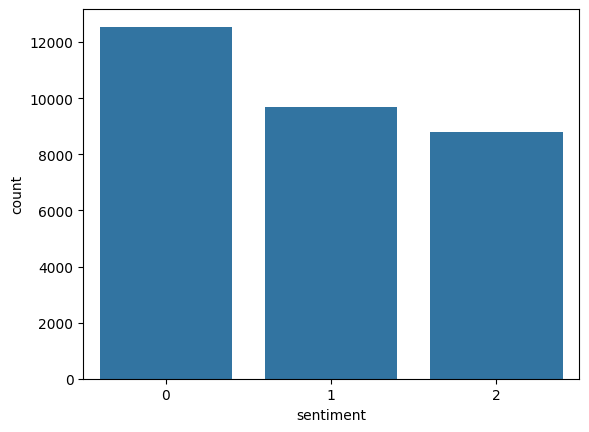

In [16]:
## Visualizing the count
# Conversion du DataFrame Spark en DataFrame Pandas
df_pandas=df.toPandas()

# Utilisation de Seaborn pour tracer le décompte des sentiments
sns.countplot(x='sentiment',data=df_pandas)

### <b>Échantillonnage pour équilibrer les classes de sentiments</b>

In [17]:
#Inference: The data is unbalanced therfore we will downsample the data to have same count for each sentiment
# Séparer les classes majoritaires et minoritaires
df_majority = df.filter(col("sentiment") == 0)
df_minority = df.filter(col("sentiment") == 2)
df_medium = df.filter(col("sentiment") == 1)

# Déterminer la taille de l'échantillon de la classe minoritaire
minority_count = df_minority.count()

# Échantillonnage aléatoire des données de la classe majoritaire pour correspondre à la taille de la classe minoritaire
df_majority_downsampled = df_majority.sample(False, minority_count / df_majority.count(), seed=1234)
df_medium_downsampled = df_medium.sample(False, minority_count / df_medium.count(), seed=1234)

# Combinez les classes majoritaires échantillonnées et les classes minoritaires
df = df_majority_downsampled.union(df_minority).union(df_medium_downsampled)


### <b>Visualisation des sentiments avant et après l'équilibrage des classes</b>

+---------+-----+
|sentiment|count|
+---------+-----+
|        0| 8797|
|        2| 8780|
|        1| 8809|
+---------+-----+



<Axes: xlabel='sentiment', ylabel='count'>

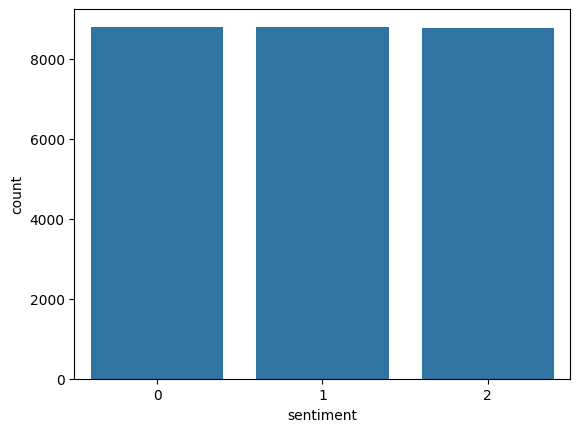

In [18]:
#visualiser les sentiment
df.groupBy('sentiment').count().show()

df_pandas=df.toPandas()
sns.countplot(x='sentiment',data=df_pandas)

### <b>Transformation de la colonne de texte</b>

In [19]:
# Appliquer les transformations sur la colonne de texte
## Convertir le texte en minuscules
df = df.withColumn('processed_text', lower(df['text']))
# Supprimer les crochets et leur contenu
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\[.*?\\]', ''))

# Supprimer les caractères non alphanumériques
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\W', ' '))
### Supprimer les URLs
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], 'https?://\\S+|www\\.\\S+', ''))
## Supprimer les balises HTML
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '<.*?>+', ''))
## Supprimer les ponctuations
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '[%s]' % re.escape(string.punctuation), ''))
## Supprimer les sauts de ligne
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\n', ''))
#
# Supprimer les chiffres et les mots contenant des chiffres
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\w*\\d\\w*', ''))


### <b>Suppression des stopwords et formation du texte final</b>

In [20]:
# Télécharger la liste des stopwords si nécessaire
nltk.download('stopwords')

# Charger la liste des stopwords en français par exemple
stop_words = set(stopwords.words('english'))

## delete stop words

# Diviser le texte en mots
df = df.withColumn('words', split(df['processed_text'], ' '))

# Charger la liste des stopwords en tant qu'ensemble pour une recherche efficace
stop_words_set = set(stop_words)

# Convertir l'ensemble de stopwords en liste
stop_words_list = list(stop_words_set)

# Créer une colonne contenant la liste des mots
stop_words_col = lit(stop_words_list)

# Filtrer les mots qui ne sont pas des stopwords
df = df.withColumn('processed_words', array_except(col('words'), stop_words_col))

# Joindre les mots filtrés pour former le texte final
df = df.withColumn('processed_text', concat_ws(' ', col('processed_words')))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### <b>Affichage de la colonne 'processed_text'</b>

In [21]:
# Afficher uniquement la colonne 'processed_text'
df.select('processed_text').show(truncate=False)


+-----------------------------------------------------------------------------------------+
|processed_text                                                                           |
+-----------------------------------------------------------------------------------------+
| go cruches next weeks                                                                   |
|coffee time  back later kisses                                                           |
| heeeey dear finally found                                                               |
| last night                                                                              |
|back uminaa                                                                              |
|grandpa telling used cut human bodies med school                                         |
|nuggets game everyoneeeee except                                                         |
| ya never watch l                                                              

### <b>Agrégation des textes par sentiment et création de nuages de mots</b>

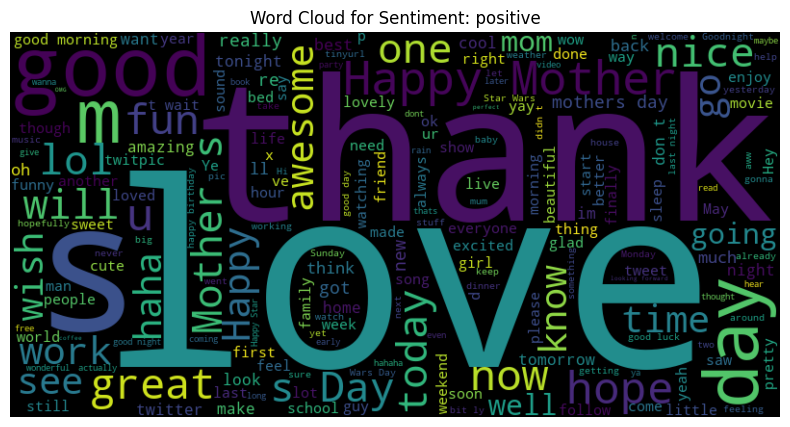

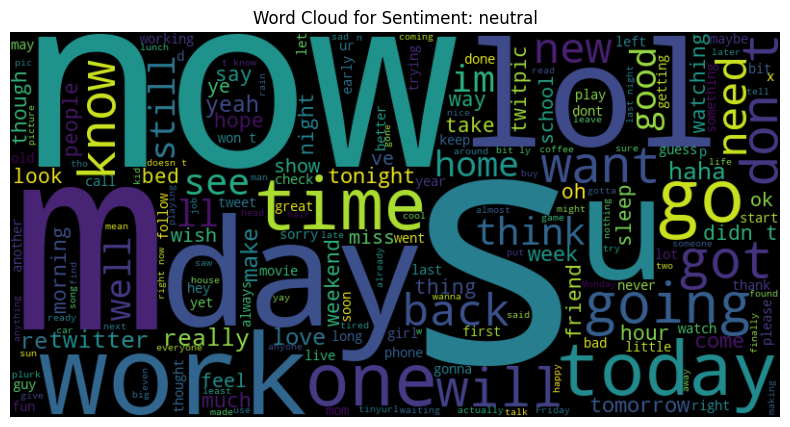

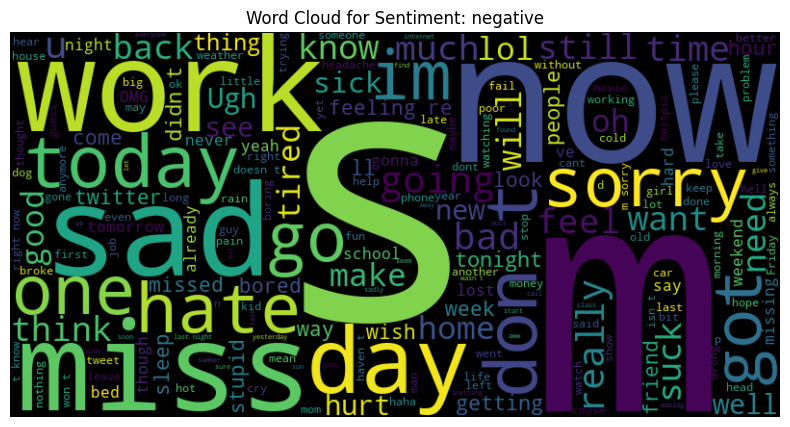

In [22]:
# Agréger les textes en fonction du sentiment
aggregated_df = df_train.groupby('sentiment').agg(concat_ws(' ', collect_list('text')).alias('text'))

# Convertir l'aggregated_df en Pandas DataFrame pour utiliser WordCloud
aggregated_pd_df = aggregated_df.toPandas()

# Créer un nuage de mots pour chaque sentiment
for index, row in aggregated_pd_df.iterrows():
    sentiment = row['sentiment']
    text = row['text']
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Sentiment: {sentiment}')
    plt.axis('off')
    plt.show()

In [23]:
# Diviser les données en ensembles de formation et de test
train_data, test_data ,val_data= df.randomSplit([0.7, 0.1,0.2],seed=42)
# Vérifier les tailles des ensembles
print("Nombre de lignes dans l'ensemble d'entraînement :", train_data.count())
print("Nombre de lignes dans l'ensemble de validation :", val_data.count())
print("Nombre de lignes dans l'ensemble de test :", test_data.count())

Nombre de lignes dans l'ensemble d'entraînement : 18634
Nombre de lignes dans l'ensemble de validation : 5151
Nombre de lignes dans l'ensemble de test : 2601
